In [4]:
# ======================
# Setup + Safe Helpers
# ======================
import sys, re, warnings, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from packaging import version

warnings.filterwarnings("ignore")

print("="*70)
print("SMU Wellness — Visual EDA + Feature Engineering + Baseline Model")
print("This notebook keeps duplicates, adds visuals, clear printouts, and")
print("handles common errors (missing columns, package versions, NaNs).")
print("="*70)

# --------------- sklearn compatibility helpers ----------------
SKL = None
try:
    import sklearn
    SKL = sklearn.__version__
    print(f"[info] scikit-learn version: {SKL}")
except Exception as e:
    print("[warn] Could not detect scikit-learn version:", e)

def make_onehot_encoder():
    """Return an OneHotEncoder that works across sklearn versions."""
    try:
        # sklearn >= 1.2 supports sparse_output
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # older versions use sparse=
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def make_calibrator(estimator, method="isotonic", cv=3):
    """Return CalibratedClassifierCV that works for old/new sklearn APIs."""
    try:
        # new API (>=1.4) uses 'estimator='
        return CalibratedClassifierCV(estimator=estimator, method=method, cv=cv)
    except TypeError:
        # older API uses 'base_estimator='
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv=cv)

# --------------- plotting niceties ----------------
def annotate_bars(ax):
    """Add value labels above bars."""
    for p in ax.patches:
        try:
            val = p.get_height()
        except Exception:
            val = p.get_width()
        if pd.notna(val) and val != 0:
            ax.annotate(f"{int(val)}", (p.get_x()+p.get_width()/2, val),
                        ha='center', va='bottom', fontsize=9, rotation=0)

def explain(title, note):
    """Print a short explanation above a section."""
    print(f"\n--- {title} ---")
    print(note)


/var/folders/qn/jfqcll4s6yz52tywvfkhzr440000gn/T/ipykernel_35551/949883544.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


SMU Wellness — Visual EDA + Feature Engineering + Baseline Model
This notebook keeps duplicates, adds visuals, clear printouts, and
handles common errors (missing columns, package versions, NaNs).
[info] scikit-learn version: 1.4.0


In [8]:
# ======================
# Load Data + Column Map
# ======================
import pandas as pd

# Load your Excel file
df = pd.read_excel('/Users/ritikabajpai/Desktop/SMU_Survey_Final.xlsx')

# Updated column maps based on actual column names in your file
KEY_COLUMNS = {
    'age': 'Age',
    'gender': 'Gender', 
    'year': 'YearOfStudy',
    'school': 'School',
    'intent_90d': 'Q27_27InTheNext90DaysHowLikelyAreYouToUseAnySmuWellnessServiceCounsellingWorkshopsEvents',
    'past_attend_count': 'Q28_28InThePast6MonthsHowManyWellnessEventsDidYouAttend',
    'no_show_count': 'Q29_29InThePast6MonthsHowManyWellnessEventsDidYouSignUpButNotAttendNoShow',
    'next_program': 'Q30_30IfYouCouldJoinExactlyOneWellnessProgramNextWhichTypeOfEventWouldYouPick',
    'preferred_format': 'Q31_31WhichFormatDoYouPreferMost',
    'preferred_time_windows': 'Q32_32WhichTimesWorkBestForYouSelectUpTo2',
    'barrier_time': 'Q33_lackOfTime',
    'barrier_cost': 'Q33_cost',
    'barrier_motivation': 'Q33_lackOfMotivationWillpower',
    'barrier_access': 'Q33_convenience',
}

RELEVANCE_COLUMNS = {
    'relevance_MHW': 'Q34_mentalHealthWeek',
    'relevance_Resilience': 'Q34_resilienceFramework',
    'relevance_ExamAngels': 'Q34_examAngels',
    'relevance_SCS': 'Q34_studentCareServices',
    'relevance_CosyHaven': 'Q34_cosyHaven',
    'relevance_Voices': 'Q34_voicesRoadshows',
    'relevance_PeerHelpers': 'Q34_peerHelpersRoadshows',
    'relevance_CareerCompass': 'Q34_careerCompass',
    'relevance_CARES': 'Q34_caresCorner'
}

use_cols = {**KEY_COLUMNS, **RELEVANCE_COLUMNS}

# Validate availability and rename to clean names
missing = [v for v in use_cols.values() if v not in df.columns]
if missing:
    raise KeyError(
        "The following expected survey columns are missing:\n"
        + "\n".join(f"- {m}" for m in missing) +
        "\nCheck the questionnaire wording/typos or update the map."
    )

data = df[list(use_cols.values())].rename(columns={v:k for k,v in use_cols.items()})
print(f"[ok] Selected {len(use_cols)} features from {len(data)} rows (duplicates retained).")


[ok] Selected 23 features from 252 rows (duplicates retained).



--- Demographics ---
Age uses a histogram; gender, year, and school are counts. Use this to confirm the sample distribution looks sensible.


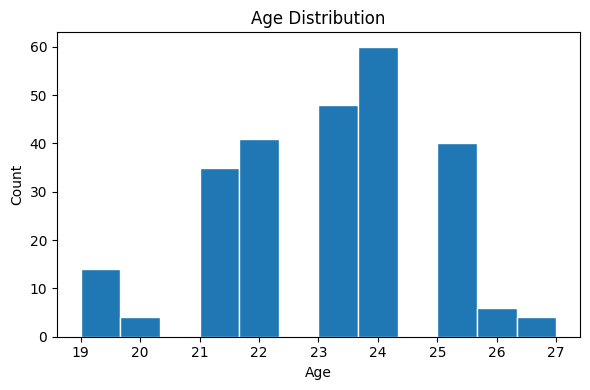

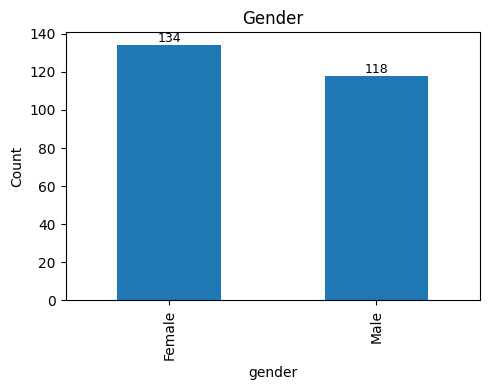

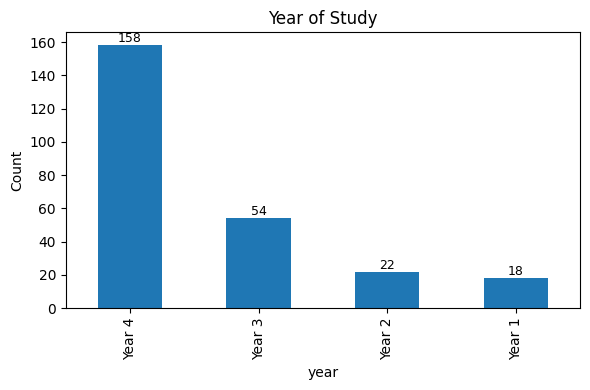

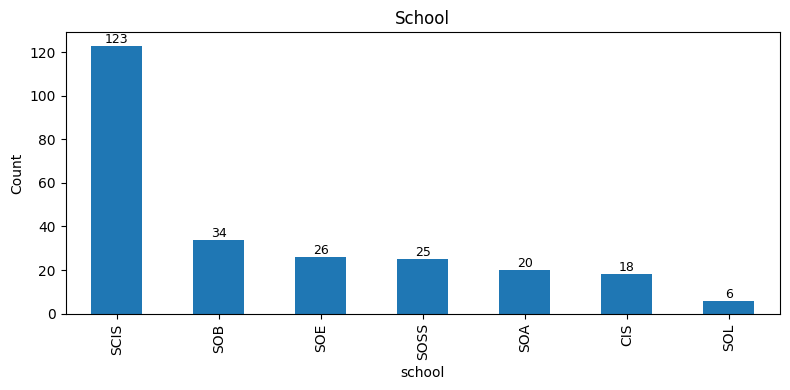


--- Intent & Behaviour ---
Intent is on a 0–10 scale (histogram). Past attendance and no-shows are categorical buckets—helpful to gauge engagement history.


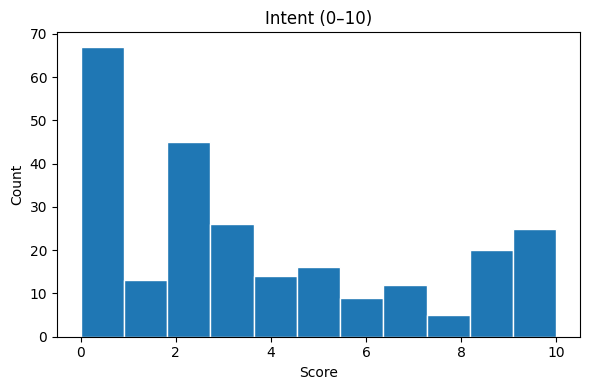

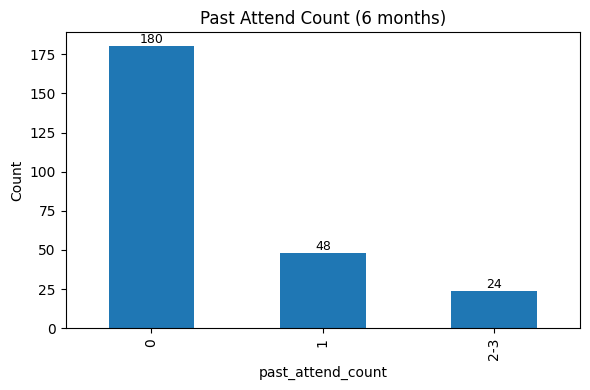

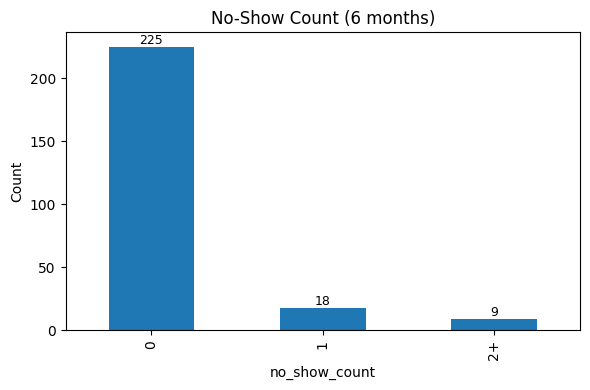


--- Preferences ---
These charts show what students say they’d pick next (program), preferred delivery format, and which time windows are most popular.


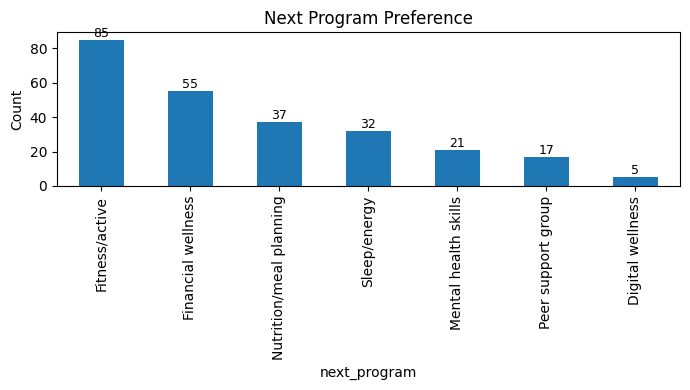

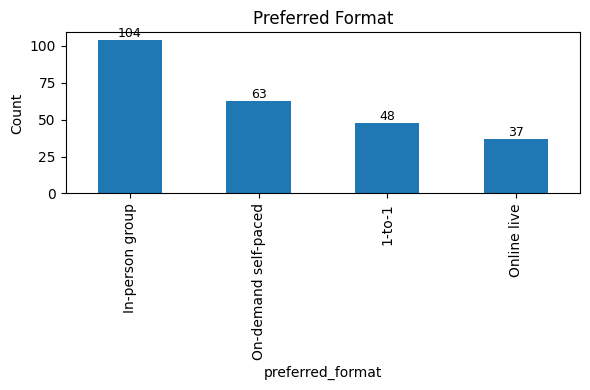

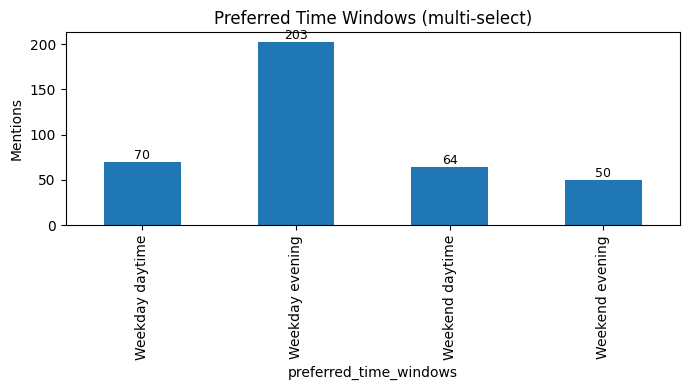


--- Barriers (0–10) ---
Higher means a larger barrier. This highlights what mainly stops students (e.g., time vs motivation).


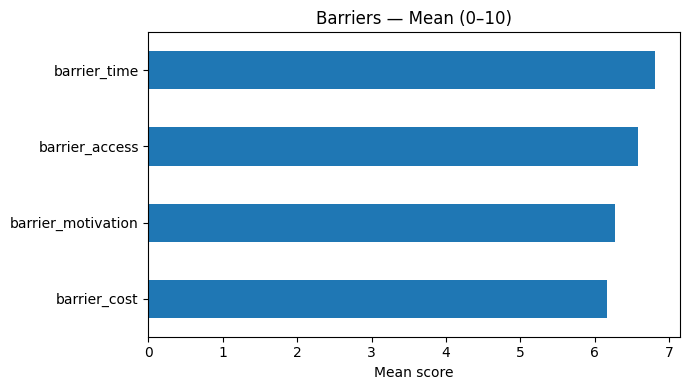


--- Initiatives relevance (1–10) ---
Which schemes feel most relevant right now? Use this to align programming and communications with perceived needs.


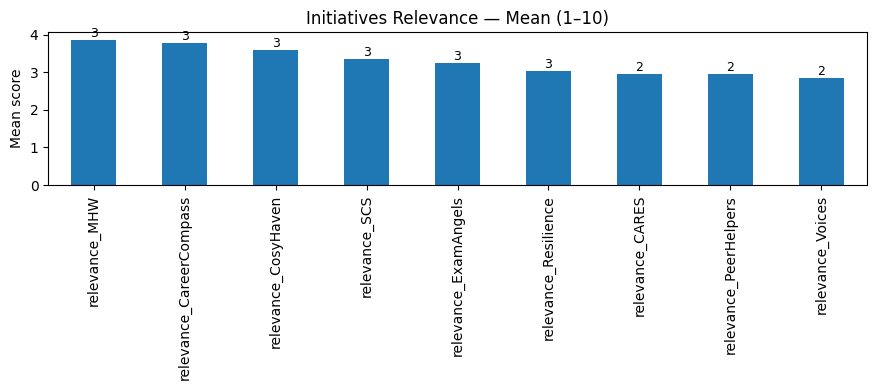


--- Correlation (numeric only) ---
Blue=negative, yellow=positive. Use this to spot simple linear relationships (e.g., intent vs barriers). Not causal, just association.


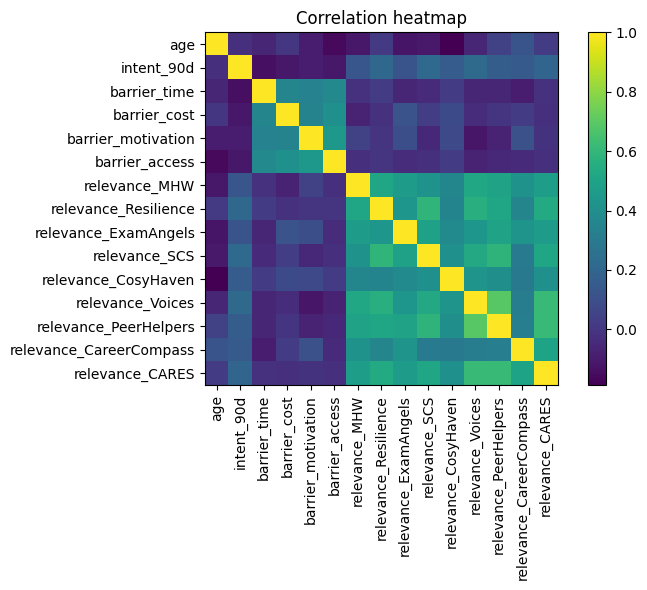

In [9]:
# ======================
# Visual EDA
# ======================
explain("Demographics", 
        "Age uses a histogram; gender, year, and school are counts. "
        "Use this to confirm the sample distribution looks sensible.")

# Age
plt.figure(figsize=(6,4))
data['age'].dropna().astype(float).plot(kind='hist', bins=12, edgecolor='white')
plt.title('Age Distribution'); plt.xlabel('Age'); plt.ylabel('Count'); plt.tight_layout()
plt.show()

# Gender
plt.figure(figsize=(5,4))
ax = data['gender'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Gender'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Year
plt.figure(figsize=(6,4))
ax = data['year'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Year of Study'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# School
plt.figure(figsize=(8,4))
ax = data['school'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('School'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Intent + behaviour
explain("Intent & Behaviour", 
        "Intent is on a 0–10 scale (histogram). Past attendance and no-shows "
        "are categorical buckets—helpful to gauge engagement history.")

plt.figure(figsize=(6,4))
data['intent_90d'].dropna().plot(kind='hist', bins=11, edgecolor='white')
plt.title('Intent (0–10)'); plt.xlabel('Score'); plt.ylabel('Count'); plt.tight_layout(); plt.show()

for col, title in [('past_attend_count','Past Attend Count (6 months)'),
                   ('no_show_count','No-Show Count (6 months)')]:
    plt.figure(figsize=(6,4))
    ax = data[col].astype(str).str.strip().value_counts().plot(kind='bar')
    plt.title(title); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Preferences
explain("Preferences", 
        "These charts show what students say they’d pick next (program), "
        "preferred delivery format, and which time windows are most popular.")

plt.figure(figsize=(7,4))
ax = data['next_program'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Next Program Preference'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
ax = data['preferred_format'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Preferred Format'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Multi-select time windows
def multi_hot_counts(series, choices):
    s = (series.fillna('')
               .astype(str)
               .str.replace(r'\s*[/;]\s*', ', ', regex=True))
    exploded = s.str.split(',').explode().str.strip()
    exploded = exploded[exploded.ne('')]
    return exploded.value_counts().reindex(choices, fill_value=0)

time_choices = ['Weekday daytime','Weekday evening','Weekend daytime','Weekend evening']
plt.figure(figsize=(7,4))
ax = multi_hot_counts(data['preferred_time_windows'], time_choices).plot(kind='bar')
plt.title('Preferred Time Windows (multi-select)'); plt.ylabel('Mentions'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Barriers
explain("Barriers (0–10)", 
        "Higher means a larger barrier. This highlights what mainly stops students "
        "(e.g., time vs motivation).")

barrier_cols = ['barrier_time','barrier_cost','barrier_motivation','barrier_access']
means = data[barrier_cols].apply(pd.to_numeric, errors='coerce').mean().sort_values()
plt.figure(figsize=(7,4))
ax = means.plot(kind='barh')
plt.title('Barriers — Mean (0–10)'); plt.xlabel('Mean score'); plt.tight_layout(); plt.show()

# Relevance of initiatives
explain("Initiatives relevance (1–10)", 
        "Which schemes feel most relevant right now? Use this to align programming "
        "and communications with perceived needs.")

rel_cols = [c for c in data.columns if c.startswith('relevance_')]
rel_means = data[rel_cols].apply(pd.to_numeric, errors='coerce').mean().sort_values(ascending=False)
plt.figure(figsize=(9,4))
ax = rel_means.plot(kind='bar')
plt.title('Initiatives Relevance — Mean (1–10)'); plt.ylabel('Mean score'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Correlations
explain("Correlation (numeric only)", 
        "Blue=negative, yellow=positive. Use this to spot simple linear relationships "
        "(e.g., intent vs barriers). Not causal, just association.")
num_cols = ['age','intent_90d'] + barrier_cols + rel_cols
corr = data[num_cols].apply(pd.to_numeric, errors='coerce').corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar(); plt.xticks(range(len(corr)), corr.columns, rotation=90); plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation heatmap'); plt.tight_layout(); plt.show()



=== Feature engineering ===
- ordinals: past_attend_count→0/1/2/3; no_show_count→0/1/2
- scaled numerics: intent/10, barriers/10, max relevance/10
- multi-hot: preferred_time_windows (4 binaries)
- one-hot: next_program, preferred_format, school, gender
- derived indices: barrier_index, scheme_relevance_max

=== Data dictionary (compact) ===
Numeric (scaled/ordinal + raw): 19
One-hot categories: ['next_program', 'preferred_format', 'school', 'gender']
Binary time-window flags: ['time_weekday_daytime', 'time_weekday_evening', 'time_weekend_daytime', 'time_weekend_evening']
Tip: Missing numeric values will be median-imputed; categorical = mode.

=== Proxy label ===
We temporarily label y=1 if intent_90d ≥ 7.
Class balance → positives=62 (24.6%), negatives=190 (75.4%).
We set class_weight='balanced' so both classes are considered fairly.
[split] train=176, valid=38, test=38

=== Calibration ===
We wrap Logistic Regression with isotonic calibration so predicted probabilities behave like r

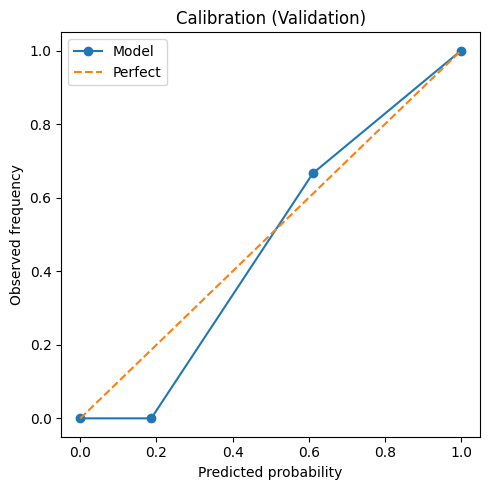

If the blue dots hug the dashed line, your probabilities are well-calibrated.

=== Driver summary skipped ===
Could not compute coefficients: '_CalibratedClassifier' object has no attribute 'coef_'


In [10]:
# ==============================================
# Feature Engineering + Calibrated Logistic Reg
# (Verbose, explain-as-you-go version)
# ==============================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, brier_score_loss,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer

def _make_onehot_encoder():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _make_calibrator(estimator, method="isotonic", cv=3):
    try:
        return CalibratedClassifierCV(estimator=estimator, method=method, cv=cv)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv=cv)

def _say(title, text):
    print(f"\n=== {title} ===")
    print(text)

# 1) Build engineered table exactly per spec
_say("Feature engineering",
    "- ordinals: past_attend_count→0/1/2/3; no_show_count→0/1/2\n"
    "- scaled numerics: intent/10, barriers/10, max relevance/10\n"
    "- multi-hot: preferred_time_windows (4 binaries)\n"
    "- one-hot: next_program, preferred_format, school, gender\n"
    "- derived indices: barrier_index, scheme_relevance_max")

def map_past(x):
    s = str(x).strip()
    if s in ['0','Zero','zero']: return 0
    if s in ['1','One','one']: return 1
    if '2-3' in s or '2 – 3' in s or '2 to 3' in s: return 2
    if '4+' in s or '4 +' in s or '4 or more' in s: return 3
    try:
        n = int(float(s))
        if n<=0: return 0
        if n==1: return 1
        if 2<=n<=3: return 2
        return 3
    except: return np.nan

def map_noshow(x):
    s = str(x).strip()
    if s in ['0','Zero','zero']: return 0
    if s in ['1','One','one']: return 1
    if '2+' in s or '2 +' in s or '2 or more' in s: return 2
    try:
        n = int(float(s))
        if n<=0: return 0
        if n==1: return 1
        return 2
    except: return np.nan

X = data.copy()
barrier_cols = ['barrier_time','barrier_cost','barrier_motivation','barrier_access']
rel_cols = [c for c in X.columns if c.startswith('relevance_')]

# Ordinals
X['past_attend_ord'] = X['past_attend_count'].map(map_past)
X['no_show_ord']     = X['no_show_count'].map(map_noshow)

# Scaled numerics & indices
X['intent_scaled']        = pd.to_numeric(X['intent_90d'], errors='coerce')/10.0
X['barrier_index']        = X[barrier_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)/10.0
X['scheme_relevance_max'] = X[rel_cols].apply(pd.to_numeric, errors='coerce').max(axis=1)/10.0

# Multi-hot: preferred time windows
time_choices = ['Weekday daytime','Weekday evening','Weekend daytime','Weekend evening']
def _split_multi(val):
    if pd.isna(val): return []
    s = re.sub(r'\s*[/;]\s*', ', ', str(val))
    return [t.strip() for t in s.split(',') if t.strip()]

for t in time_choices:
    X[f'time_{t.replace(" ","_").lower()}'] = X['preferred_time_windows'].apply(lambda v: 1 if t in _split_multi(v) else 0)

# Define feature roles
num_feats = ['intent_scaled','barrier_index','scheme_relevance_max','age','past_attend_ord','no_show_ord',
             'barrier_time','barrier_cost','barrier_motivation','barrier_access'] + rel_cols
cat_onehot = ['next_program','preferred_format','school','gender']
bin_feats = [c for c in X.columns if c.startswith('time_')]

# Show a compact data dictionary
_say("Data dictionary (compact)",
    f"Numeric (scaled/ordinal + raw): {len(num_feats)}\n"
    f"One-hot categories: {cat_onehot}\n"
    f"Binary time-window flags: {bin_feats}\n"
    "Tip: Missing numeric values will be median-imputed; categorical = mode.")

# 2) Proxy label & class balance
y = (pd.to_numeric(X['intent_90d'], errors='coerce') >= 7).astype(int)
pos, neg = int(y.sum()), int((1-y).sum())
_say("Proxy label",
    f"We temporarily label y=1 if intent_90d ≥ 7.\n"
    f"Class balance → positives={pos} ({pos/len(y):.1%}), negatives={neg} ({neg/len(y):.1%}).\n"
    "We set class_weight='balanced' so both classes are considered fairly.")

# 3) Splits
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)
print(f"[split] train={len(X_train)}, valid={len(X_valid)}, test={len(X_test)}")

# 4) Preprocess
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('onehot',  _make_onehot_encoder())])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_onehot),
    ('bin', 'passthrough', bin_feats)
], remainder='drop')

# 5) Model + calibration (with explanation)
base = LogisticRegression(max_iter=2000, class_weight='balanced')
clf  = _make_calibrator(base, method='isotonic', cv=3)

_say("Calibration",
    "We wrap Logistic Regression with isotonic calibration so predicted "
    "probabilities behave like real-world chances (e.g., 0.70 ≈ 70% attend).")

pipe = Pipeline([('prep', preprocessor), ('clf', clf)])

try:
    pipe.fit(X_train, y_train)
    print("[ok] Trained + calibrated.")
except Exception as e:
    _say("Training error",
        "Common causes:\n"
        "- Non-numeric values in numeric columns that couldn’t be coerced\n"
        "- Columns that became all-NaN after selection\n"
        "- Package version mismatch\n"
        f"Raw error: {e}")
    raise

# 6) Metrics + explanations
def _report(split, Xs, ys):
    p = pipe.predict_proba(Xs)[:,1]
    yhat = (p >= 0.5).astype(int)
    print(f"\n--- {split} metrics ---")
    print(f"AUROC : {roc_auc_score(ys, p):.3f}  → ranking quality; 0.5=chance, 1.0=perfect")
    print(f"PR-AUC: {average_precision_score(ys, p):.3f}  → precision–recall area; useful with imbalance")
    print(f"F1@0.5: {f1_score(ys, yhat):.3f}  → balance of precision & recall at 0.5 threshold")
    print(f"Brier : {brier_score_loss(ys, p):.3f}  → prob. calibration error; lower is better (≈0 best)")
    return p

p_tr = _report("Train", X_train, y_train)
p_va = _report("Valid", X_valid, y_valid)
p_te = _report("Test ", X_test,  y_test)

# 7) Recommend operational buckets on the validation set
_say("Operating policy (validation)",
    "We form three action buckets on validation predictions:\n"
    "  • LOW   : p < 0.35  → deprioritize or light-touch nudge\n"
    "  • MEDIUM: 0.35–0.70 → normal comms; consider incentives\n"
    "  • HIGH  : p ≥ 0.70  → priority invites, personalized nudges")

def bucketize(p):
    cats = pd.cut(p, bins=[-1,0.35,0.70,1.01], labels=['LOW','MED','HIGH'])
    return cats

val_buckets = bucketize(p_va)
val_summary = pd.crosstab(val_buckets, y_valid, rownames=['bucket'], colnames=['actual'])
print("\n[validation bucket vs actual]")
print(val_summary)
print("\nInterpretation:")
print("- Within HIGH, a greater share of actual 1s means your threshold is useful for targeting.")
print("- Adjust 0.35/0.70 to trade off coverage vs precision for campaigns.")

# 8) Reliability (calibration) curve – with plain-English caption
try:
    prob_true, prob_pred = [], []
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_valid, p_va, n_bins=10, strategy='quantile')
    plt.figure(figsize=(5,5))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0,1],[0,1],'--', label='Perfect')
    plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency'); plt.title('Calibration (Validation)')
    plt.legend(); plt.tight_layout(); plt.show()
    print("If the blue dots hug the dashed line, your probabilities are well-calibrated.")
except Exception:
    pass

# 9) “Top drivers” (global) with a short, readable mapping
try:
    clf_cv = pipe.named_steps['clf']
    coefs = np.mean([est.coef_.ravel() for est in clf_cv.calibrated_classifiers_], axis=0)
    # Get expanded feature names
    try:
        ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
        ohe_names = list(ohe.get_feature_names_out(cat_onehot))
    except Exception:
        ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
        ohe_names = list(ohe.get_feature_names(cat_onehot))
    final_features = list(num_feats) + ohe_names + bin_feats

    drivers = pd.Series(coefs, index=final_features).sort_values(key=np.abs, ascending=False)
    top = drivers.head(15).rename("coef")
    # Friendly interpretation column
    def _how(f, c):
        direction = "↑ raises" if c>0 else "↓ lowers"
        if f.startswith('time_'):
            return f"Time-window flag ({f.replace('time_','').replace('_',' ')}) {direction} p(attend)"
        if f in ['intent_scaled','barrier_index','scheme_relevance_max','age','past_attend_ord','no_show_ord']:
            return f"{f} {direction} p(attend)"
        if 'relevance_' in f or 'barrier_' in f:
            return f"{f} {direction} p(attend)"
        return f"{f} {direction} p(attend)"
    interp = pd.DataFrame({
        "feature": top.index,
        "coef": top.values,
        "explanation": [ _how(f,c) for f,c in top.items() ]
    })
    print("\nTop drivers (global, logistic-regression coefficients):")
    display(interp)
    print("Note: coefficients act on the log-odds. Bigger |coef| = stronger influence.")
except Exception as e:
    _say("Driver summary skipped", f"Could not compute coefficients: {e}")
